# Telecom X - Análise de Evasão de Clientes (Churn)

---

## 1. Introdução

Análise de churn realizada com base em dados históricos da Telecom X, com o objetivo de identificar padrões que explicam a evasão de clientes.

---

## 2. Extração de Dados




In [25]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from matplotlib import gridspec
from IPython.display import Markdown
import seaborn as sns

# Carregar JSON aninhado e normalizar
df_json = pd.read_json('/content/TelecomX_Data_Jason.json')
df = pd.json_normalize(df_json.to_dict(orient='records'), sep='_')
df_json.head(2)

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


## 3. Dicionário de Dados

Apresentação dos principais campos disponíveis no dataset, com breve descrição de cada variável.

* **customerID**: Número de identificação único de cada cliente.
* **Churn**: Indica se o cliente deixou ou não a empresa ('Yes' para sim, 'No' para não).
* **gender**: Gênero (masculino e feminino).
* **SeniorCitizen**: Informação sobre um cliente ter ou não idade igual ou maior que 65 anos.
* **Partner**: Se o cliente possui ou não parceiro(a).
* **Dependents**: Se o cliente possui ou não dependentes.
* **Tenure**: Meses de contrato do cliente com a empresa.
* **PhoneService**: Assinatura de serviço telefônico.
* **MultipleLines**: Assinatura de mais de uma linha de telefone.
* **InternetService**: Assinatura de um provedor de internet.
* **OnlineSecurity**: Assinatura adicional de segurança on-line.
* **OnlineBackup**: Assinatura adicional de backup online.
* **DeviceProtection**: Assinatura adicional de proteção no dispositivo.
* **TechSupport**: Assinatura adicional de suporte técnico, menos tempo de espera.
* **StreamingTV**: Assinatura de TV a cabo.
* **StreamingMovies**: Assinatura de streaming de filmes.
* **Contract**: Tipo de contrato.
* **PaperlessBilling**: Se o cliente prefere receber uma fatura online.
* **PaymentMethod**: Forma de pagamento.
* **MonthlyCharges**: Total de todos os serviços do cliente por mês.
* **TotalCharges**: Gasto total acumulado pelo cliente.
* **DailyCharges**: Valor médio gasto pelo cliente por dia, calculado a partir de TotalCharges / Tenure.

---

## 4. Limpeza e Padronização dos Dados

In [26]:
# Renomear colunas para facilitar a manipulação
df = df.rename(columns={
    'customerID': 'CustomerID',
    'Churn': 'Churn',
    'customer_gender': 'Gender',
    'customer_SeniorCitizen': 'SeniorCitizen',
    'customer_Partner': 'Partner',
    'customer_Dependents': 'Dependents',
    'customer_tenure': 'Tenure',
    'phone_PhoneService': 'PhoneService',
    'phone_MultipleLines': 'MultipleLines',
    'internet_InternetService': 'InternetService',
    'internet_OnlineSecurity': 'OnlineSecurity',
    'internet_OnlineBackup': 'OnlineBackup',
    'internet_DeviceProtection': 'DeviceProtection',
    'internet_TechSupport': 'TechSupport',
    'internet_StreamingTV': 'StreamingTV',
    'internet_StreamingMovies': 'StreamingMovies',
    'account_Contract': 'Contract',
    'account_PaperlessBilling': 'PaperlessBilling',
    'account_PaymentMethod': 'PaymentMethod',
    'account_Charges_Monthly': 'MonthlyCharges',
    'account_Charges_Total': 'TotalCharges'
})

In [27]:
# Tratamento de dados nulos e conversão de tipos
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
df.drop_duplicates(inplace=True)

# Padronização de strings
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.strip().str.capitalize()

# Limpeza da variável alvo
df['Churn'] = df['Churn'].astype(str).str.strip().str.capitalize()
df = df[df['Churn'].isin(['Yes', 'No'])].copy()

# Conversão de binário para texto
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

### Tratamento de Categorias Especiais

In [28]:
# Correção de valores irrelevantes
cols_internet = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]
for col in cols_internet:
    df[col] = df[col].replace('No internet service', 'No')

df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')

## 5. Engenharia de Atributos

In [29]:
# Variáveis derivadas
df = df[df['Tenure'] > 0].copy()  # Filtra registros com Tenure igual a 0

df['DailyCharges'] = df['TotalCharges'] / df['Tenure']

servicos = [
    'PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]
df['ServiceCount'] = df[servicos].apply(lambda row: sum(val == 'Yes' for val in row), axis=1)

# Gasto Médio por Serviço Ativo
df['AvgServiceCost'] = df['MonthlyCharges'] / df['ServiceCount'].replace(0, np.nan)

# Agrupamento por tempo de fidelidade
df['TenureGroup'] = pd.cut(df['Tenure'], bins=[0, 12, 24, 36, 48, 60, 72],
                           labels=['0–12', '13–24', '25–36', '37–48', '49–60', '61–72'])

# Reorganização das colunas
df.drop(columns=['CustomerID'], inplace=True)
colunas = df.columns.tolist()
colunas.remove('DailyCharges')
colunas.remove('AvgServiceCost')
colunas.insert(colunas.index('MonthlyCharges'), 'DailyCharges')
colunas.insert(colunas.index('MonthlyCharges') + 1, 'AvgServiceCost')
df = df[colunas]

## 6. Análises Agregadas por Categoria

In [30]:
# Análise de churn por tempo de fidelidade
churn_por_tempo = df.groupby('TenureGroup', observed=True)['Churn'].value_counts(normalize=True).unstack()
churn_por_tempo.to_html("churn_por_tempo.html")

# Análise de churn por tipo de contrato
churn_por_contrato = df.groupby('Contract')['Churn'].value_counts(normalize=True).unstack()
churn_por_contrato.to_html("churn_por_contrato.html")

# Análise de churn por serviços de retenção
servicos_relevantes = ['OnlineSecurity', 'DeviceProtection', 'TechSupport']
for servico in servicos_relevantes:
    tabela = df.groupby(servico)['Churn'].value_counts(normalize=True).unstack()
    tabela.to_html(f"churn_por_{servico.lower()}.html")

# Análise de churn por forma de pagamento
churn_por_pagamento = df.groupby('PaymentMethod')['Churn'].value_counts(normalize=True).unstack()
churn_por_pagamento.to_html("churn_por_pagamento.html")

# Análise demográfica de churn
variaveis_segmento = ['SeniorCitizen', 'Partner', 'Dependents']
for var in variaveis_segmento:
    tabela = df.groupby(var)['Churn'].value_counts(normalize=True).unstack()
    tabela.to_html(f"churn_por_{var.lower()}.html")

# Interação entre Contract e PaymentMethod
interacao = df.groupby(['Contract', 'PaymentMethod'])['Churn'].value_counts(normalize=True).unstack()
interacao.to_html("churn_interacao_contract_payment.html")

## 7. Estrutura e Estatísticas do Dataset

In [31]:
# Informações gerais
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Churn             7032 non-null   object  
 1   Gender            7032 non-null   object  
 2   SeniorCitizen     7032 non-null   object  
 3   Partner           7032 non-null   object  
 4   Dependents        7032 non-null   object  
 5   Tenure            7032 non-null   int64   
 6   PhoneService      7032 non-null   object  
 7   MultipleLines     7032 non-null   object  
 8   InternetService   7032 non-null   object  
 9   OnlineSecurity    7032 non-null   object  
 10  OnlineBackup      7032 non-null   object  
 11  DeviceProtection  7032 non-null   object  
 12  TechSupport       7032 non-null   object  
 13  StreamingTV       7032 non-null   object  
 14  StreamingMovies   7032 non-null   object  
 15  Contract          7032 non-null   object  
 16  PaperlessBilling  7032 non-nu

In [32]:
# Estatísticas descritivas
df.describe()

,Tenure,DailyCharges,MonthlyCharges,AvgServiceCost,TotalCharges,ServiceCount
count,7032.000000,7032.000000,7032.000000,6952.000000,7032.000000,7032.000000
mean,32.421786,64.799424,64.798208,26.040390,2283.300441,2.941411
std,24.545260,30.185891,30.085974,13.913750,2266.771362,1.843695
min,1.000000,13.775000,18.250000,10.416667,18.800000,0.000000
25%,9.000000,36.179891,35.587500,18.366667,401.450000,1.000000
50%,29.000000,70.373239,70.350000,20.830000,1397.475000,3.000000
75%,55.000000,90.179560,89.862500,28.266667,3794.737500,4.000000
max,72.000000,121.400000,118.750000,77.900000,8684.800000,7.000000


## 8. Análise de Correlação

In [33]:
# Correlação entre variáveis numéricas
df[['Tenure', 'MonthlyCharges', 'TotalCharges']].corr()

,Tenure,MonthlyCharges,TotalCharges
Tenure,1.000000,0.246862,0.825880
MonthlyCharges,0.246862,1.000000,0.651065
TotalCharges,0.825880,0.651065,1.000000


In [34]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))  # correção de bias
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Calcular Cramer's V para Contract e Churn
cramers_v_contract_churn = cramers_v(df['Contract'], df['Churn'])
print(f"\nCramer's V between Contract and Churn: {cramers_v_contract_churn:.2f}")


Cramer's V between Contract and Churn: 0.41


## 9. Preparação para Visualizações

In [35]:
# Adiciona uma coluna binária para churn
df['Churn_binary'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

## 10. Análise Exploratória Visual (EDA)

### 10.1 Distribuição de Variáveis Numéricas por Churn




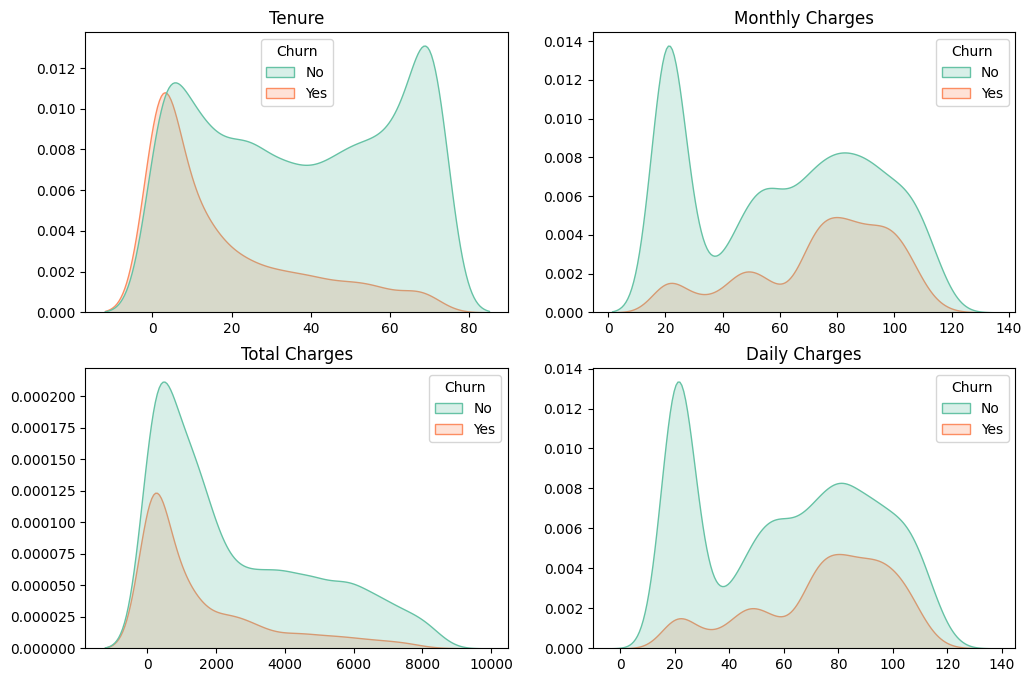

In [36]:
# Análise inicial das variáveis contínuas para verificar padrões de churn
variaveis = ['Tenure', 'MonthlyCharges', 'TotalCharges', 'DailyCharges']
titulos = ['Tenure', 'Monthly Charges', 'Total Charges', 'Daily Charges']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axs = axs.flatten()

for i, col in enumerate(variaveis):
    sns.kdeplot(data=df, x=col, hue='Churn', fill=True, palette='Set2', ax=axs[i])
    axs[i].set_title(titulos[i])
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

# Salvar como imagem PNG
plt.savefig('kde_numerical_distributions.png', dpi=300, bbox_inches='tight')

plt.show()

### 10.2 Churn por Tipo de Contrato

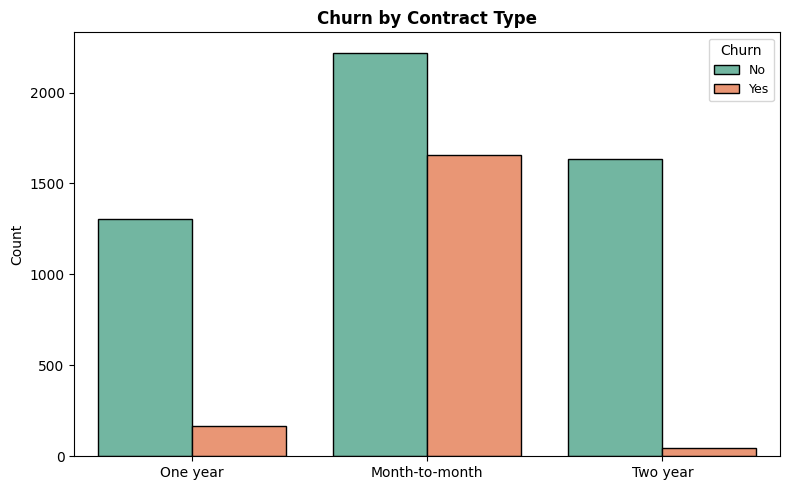

In [37]:
# Gráfico de Barras: Churn por Tipo de Contrato
plt.figure(figsize=(8, 5))

# Cores consistentes
cores = ['#66c2a5', '#fc8d62']

sns.countplot(
    data=df,
    x='Contract',
    hue='Churn',
    palette=cores,
    edgecolor='black'
)
plt.title('Churn by Contract Type', fontsize=12, weight='bold')
plt.xlabel('')
plt.ylabel('Count')
plt.legend(title='Churn', fontsize=9, title_fontsize=10, loc='upper right')
plt.tight_layout()

# Salvar como imagem PNG
plt.savefig('churn_by_contract_type.png', dpi=300, bbox_inches='tight')

plt.show()

### 10.3 Churn por Perfil Demográfico

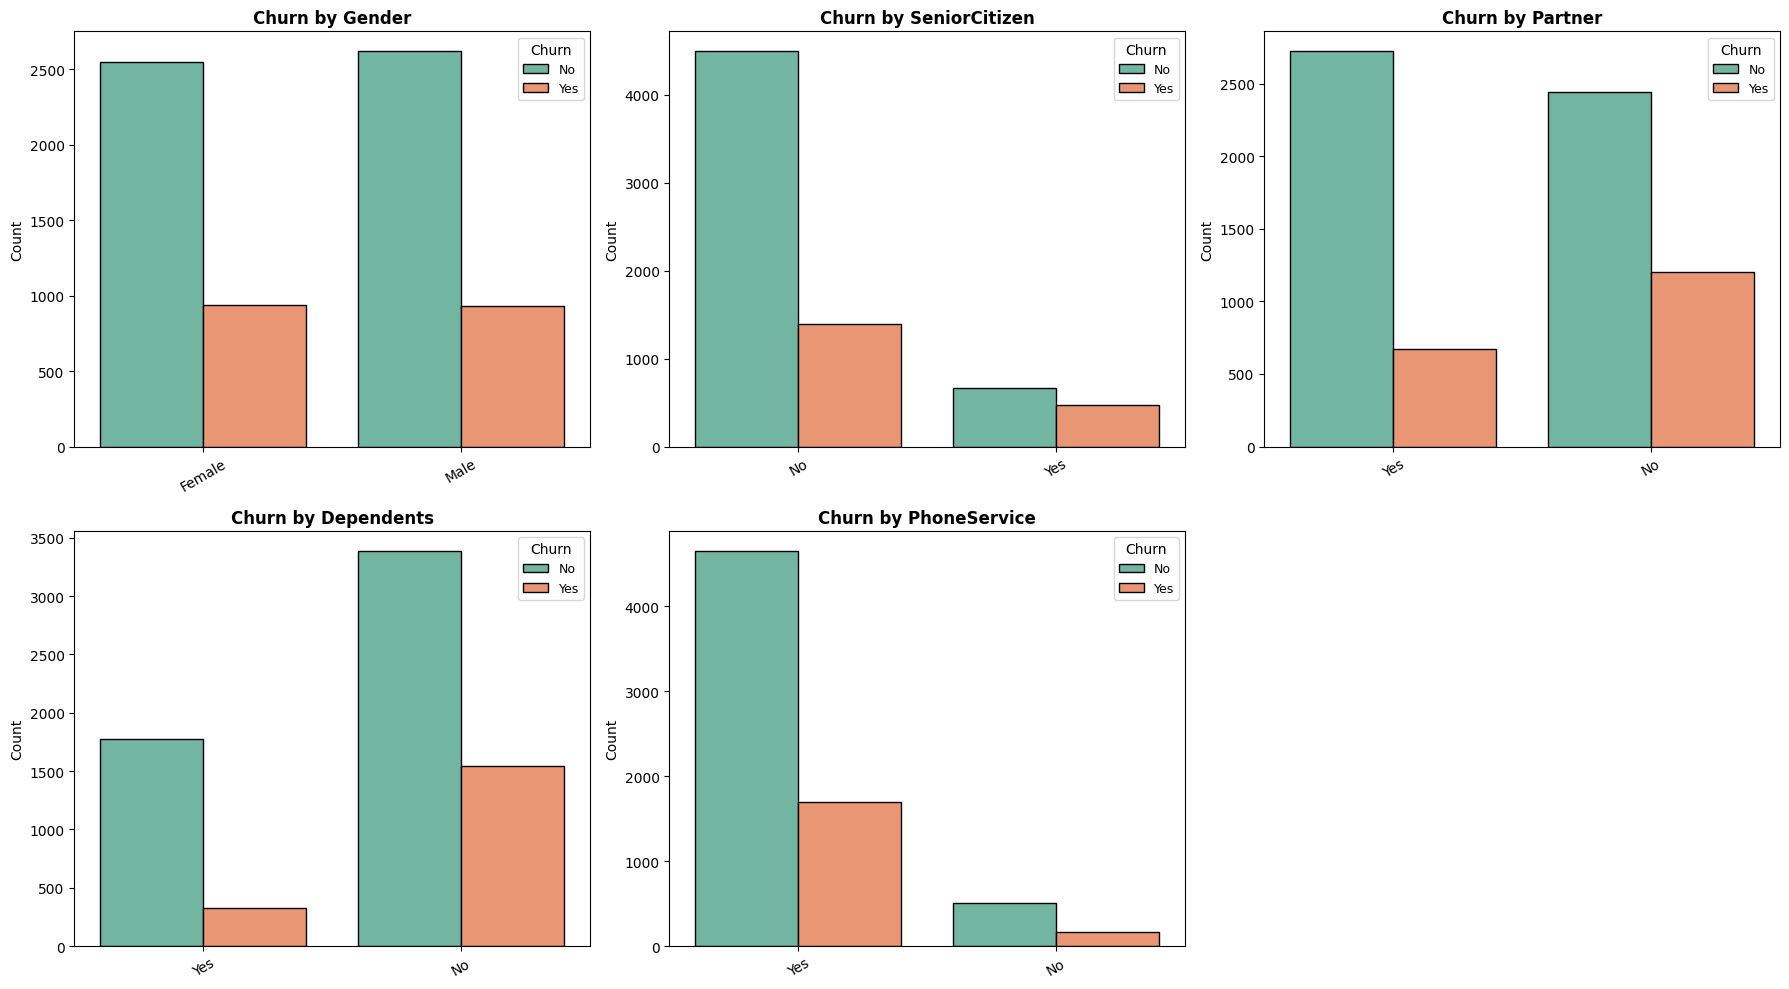

In [38]:
# Grupo de colunas relacionadas ao perfil demográfico
grupo_1 = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService']

# Subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

# Cores consistentes
cores = ['#66c2a5', '#fc8d62']

for i, col in enumerate(grupo_1):
    sns.countplot(
        data=df,
        x=col,
        hue='Churn',
        palette=cores,
        ax=axs[i],
        edgecolor='black'
    )
    axs[i].set_title(f'Churn by {col}', fontsize=12, weight='bold')
    axs[i].tick_params(axis='x', rotation=30)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Count')
    axs[i].legend(title='Churn', fontsize=9, title_fontsize=10, loc='upper right')

# Remover eixos vazios, se houver
for j in range(len(grupo_1), len(axs)):
    fig.delaxes(axs[j])

# Layout e salvamento
plt.tight_layout()
plt.savefig('demographic_profile.png', dpi=300, bbox_inches='tight')

plt.show()

### 10.4 Churn por Quantidade de Serviços Contratados

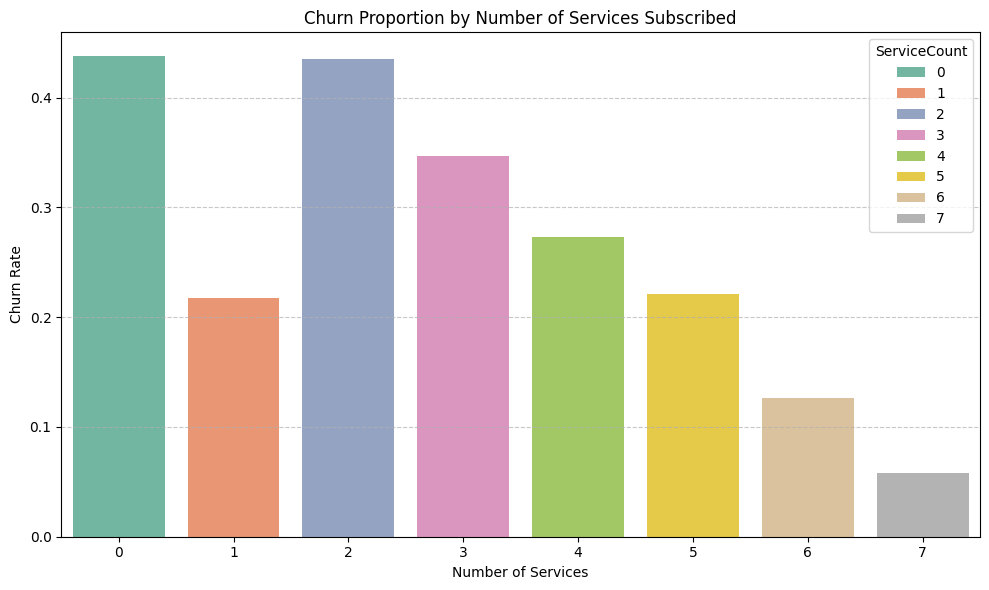

In [39]:
# Adiciona uma coluna binária para churn
df['Churn_binary'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Cálculo da taxa de churn por quantidade de serviços
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x='ServiceCount',
    y='Churn_binary',
    hue='ServiceCount',
    palette='Set2',
    estimator='mean',
    errorbar=None
)
plt.title('Churn Proportion by Number of Services Subscribed')
plt.ylabel('Churn Rate')
plt.xlabel('Number of Services')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('churn_by_service_count.png', dpi=300, bbox_inches='tight')

plt.show()

### 10.5 Churn por Serviços Adicionais  

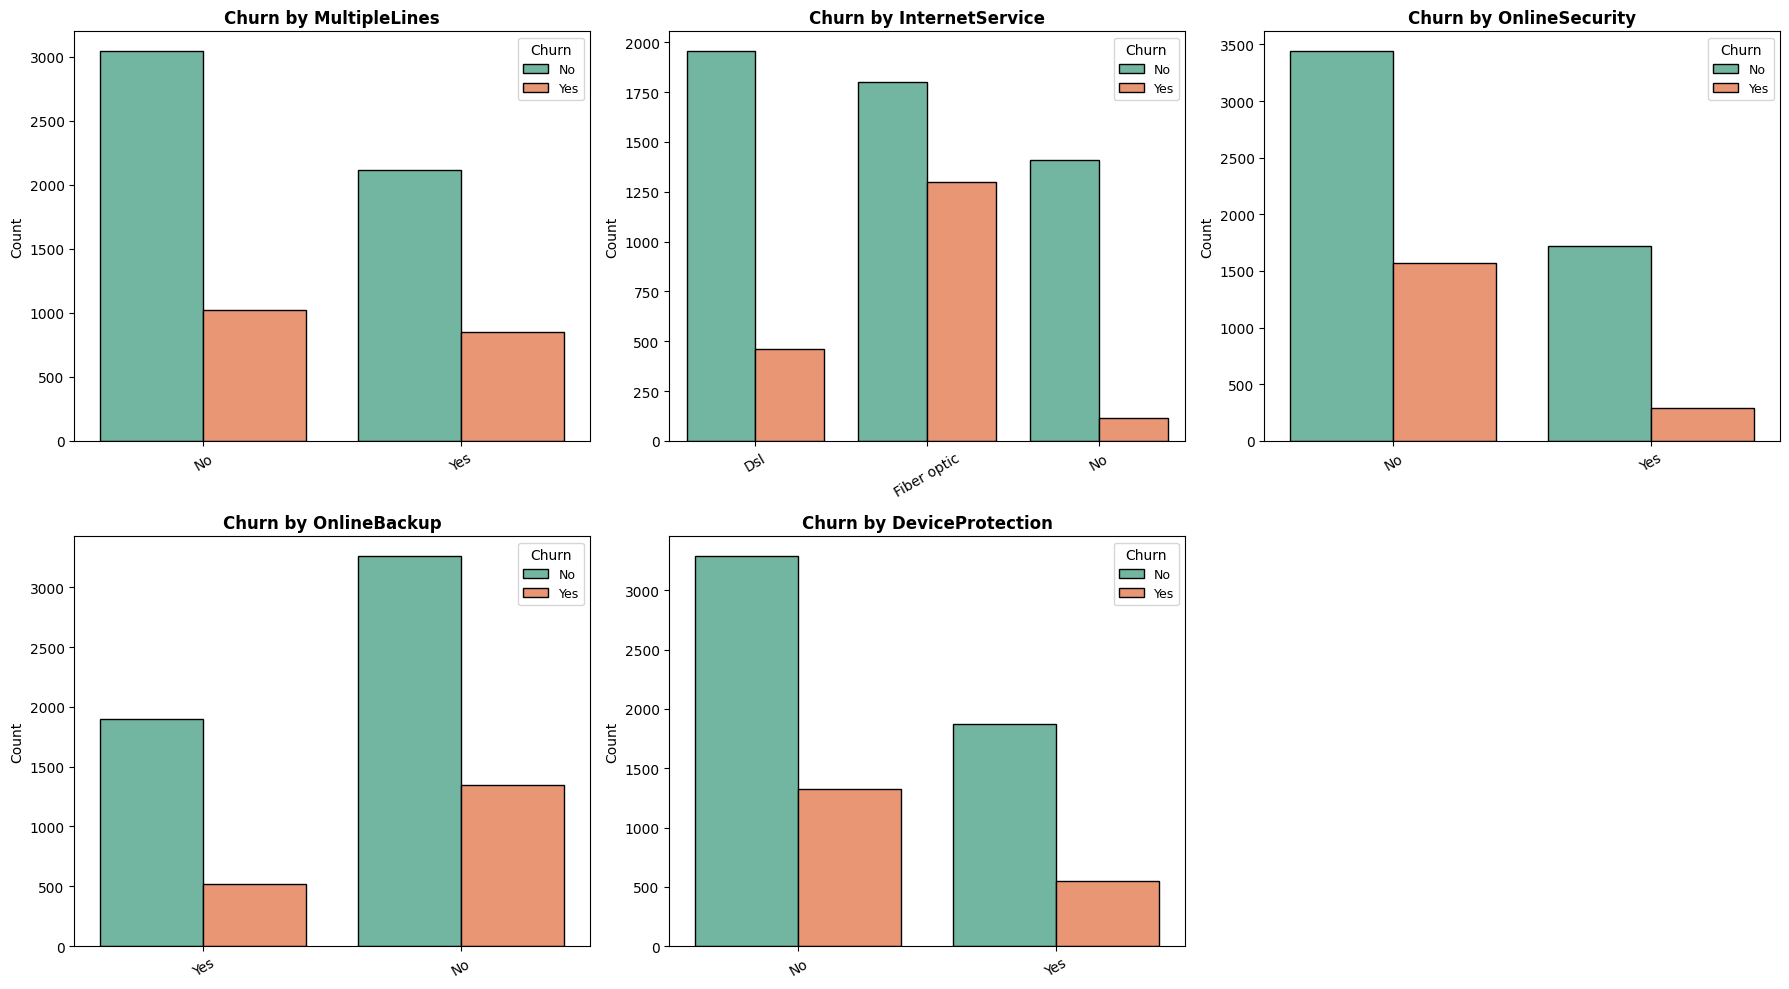

In [40]:
# Grupo de colunas relacionadas a serviços contratados
grupo_2 = [
    'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection'
]

# Subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

# Cores consistentes
cores = ['#66c2a5', '#fc8d62']

for i, col in enumerate(grupo_2):
    sns.countplot(
        data=df,
        x=col,
        hue='Churn',
        palette=cores,
        ax=axs[i],
        edgecolor='black'
    )
    axs[i].set_title(f'Churn by {col}', fontsize=12, weight='bold')
    axs[i].tick_params(axis='x', rotation=30)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Count')
    axs[i].legend(title='Churn', fontsize=9, title_fontsize=10, loc='upper right')

# Remover eixos vazios, se houver
for j in range(len(grupo_2), len(axs)):
    fig.delaxes(axs[j])

# Layout e salvamento
plt.tight_layout()
plt.savefig('subscribed_services.png', dpi=300, bbox_inches='tight')

plt.show()

### 10.6 Churn por Suporte e Cobrança

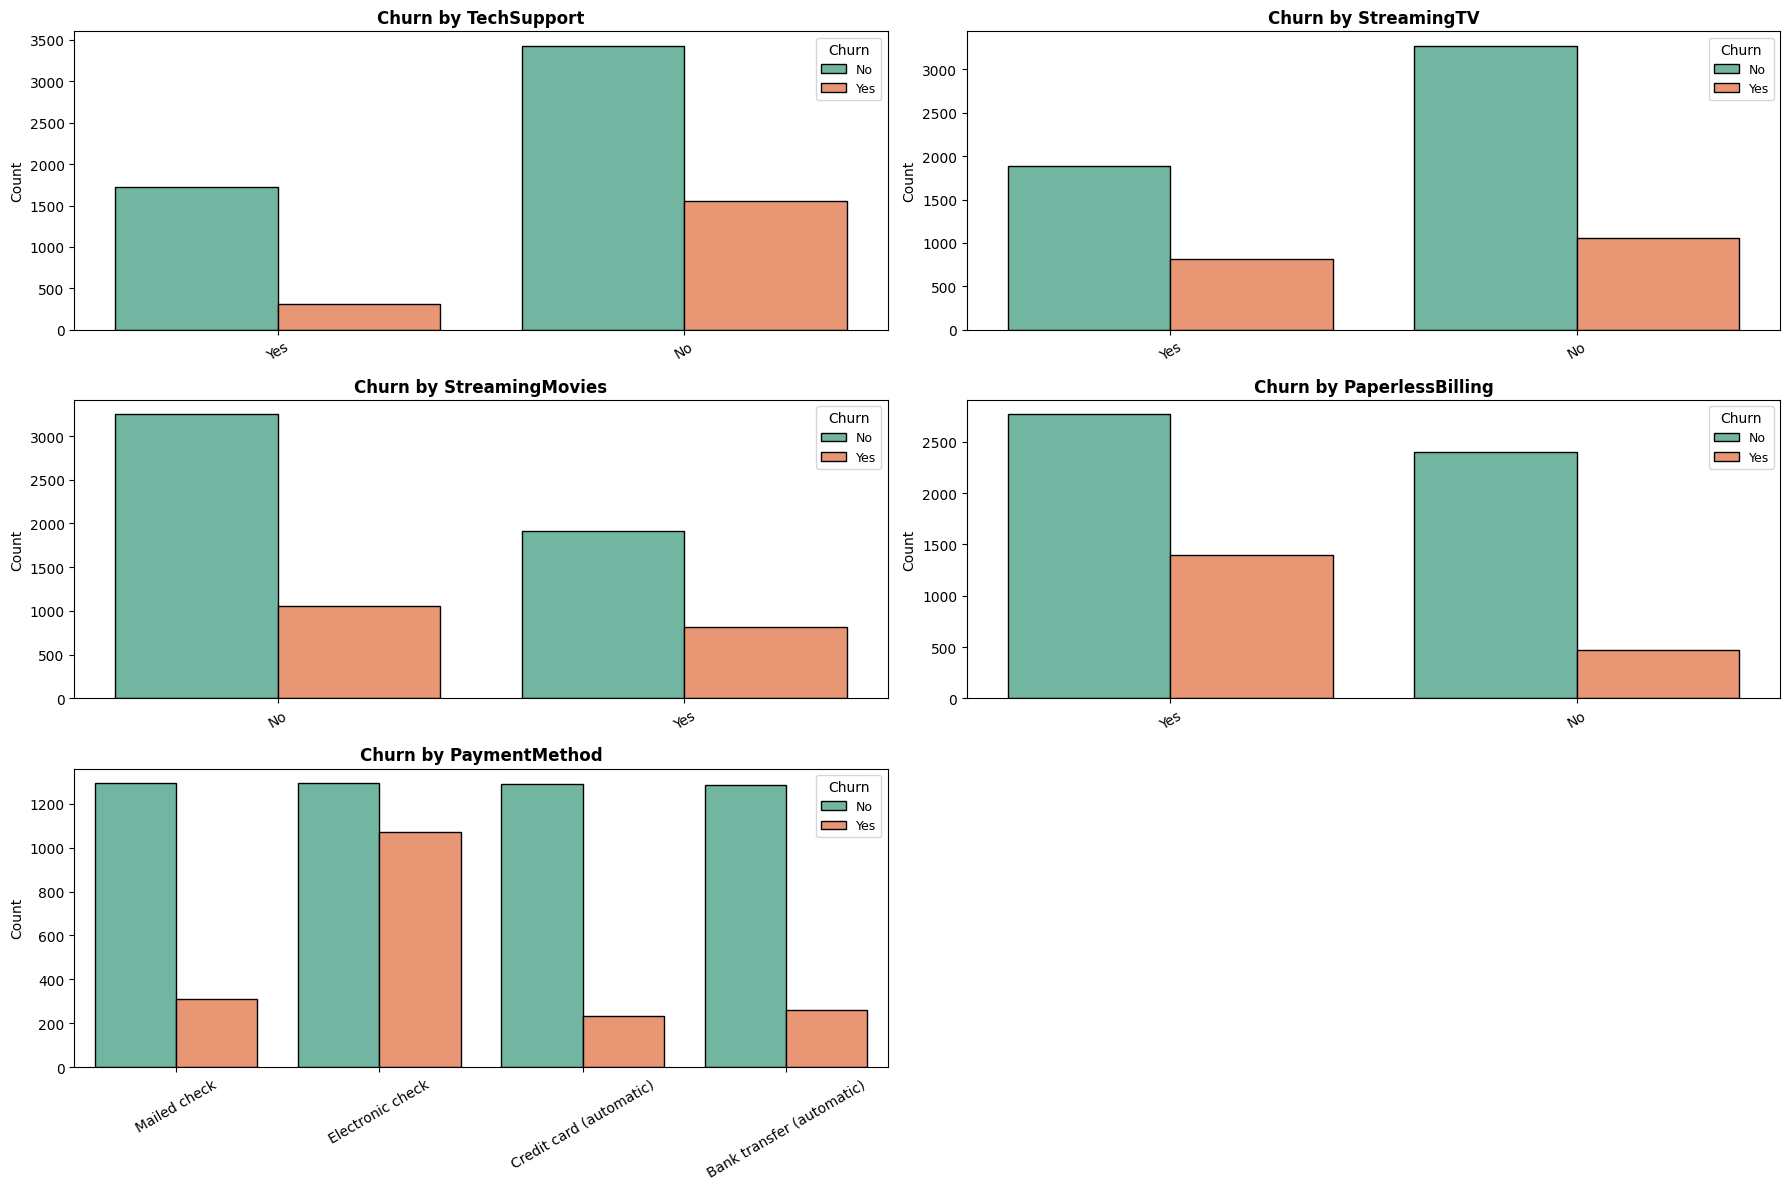

In [41]:
# Grupo de colunas relacionadas a uso e pagamento
grupo_3 = [
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'PaperlessBilling', 'PaymentMethod'
]

# Criação de figura e grid layout 3x2
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(3, 2, figure=fig)

# Paleta consistente
cores = ['#66c2a5', '#fc8d62']

# Plotagem distribuída manualmente
for i, col in enumerate(grupo_3):
    ax = fig.add_subplot(gs[i])
    sns.countplot(
        data=df,
        x=col,
        hue='Churn',
        palette=cores,
        edgecolor='black',
        ax=ax
    )
    ax.set_title(f'Churn by {col}', fontsize=12, weight='bold')
    ax.tick_params(axis='x', rotation=30)
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.legend(title='Churn', fontsize=9, title_fontsize=10, loc='upper right')

# Ajustar e exportar
plt.tight_layout()
plt.savefig('usage_payment.png', dpi=300, bbox_inches='tight')

plt.show()

### 10.7 Churn por Tempo de Fidelidade (Gráfico Empilhado)

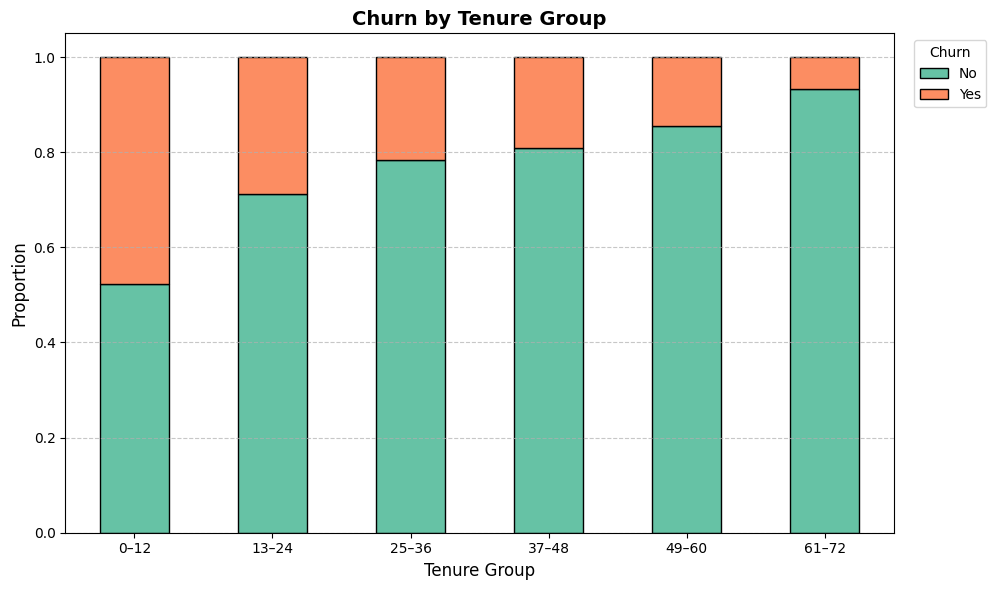

In [42]:
# Gráfico de barras empilhadas com refinamento visual e exportação automática
ax = churn_por_tempo.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#66c2a5', '#fc8d62'],
    edgecolor='black'
)

# Títulos e legendas
plt.title('Churn by Tenure Group', fontsize=14, weight='bold')
plt.ylabel('Proportion', fontsize=12)
plt.xlabel('Tenure Group', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Legenda posicionada fora do gráfico
plt.legend(title='Churn', loc='upper right', bbox_to_anchor=(1.12, 1))

# Ajustar layout
plt.tight_layout()

# Salvar o gráfico como imagem PNG em alta resolução
plt.savefig('churn_by_tenure_group.png', dpi=300, bbox_inches='tight')

plt.show()

### 10.8 Distribuição do Número de Serviços vs Churn (Boxplot)  

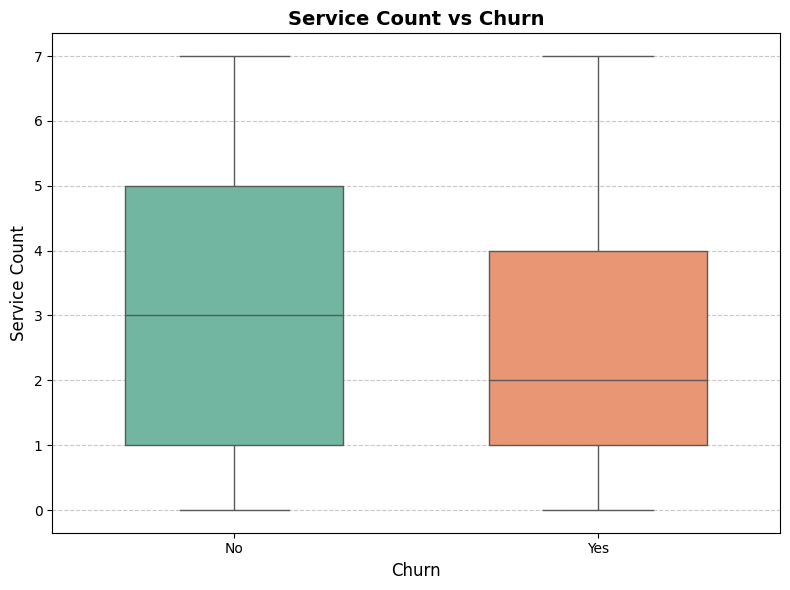

In [43]:
# Gráfico boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df,
    x='Churn',
    y='ServiceCount',
    hue='Churn',
    palette=['#66c2a5', '#fc8d62'],
    width=0.6,
    legend=False
)

plt.title('Service Count vs Churn', fontsize=14, weight='bold')
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Service Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exportar imagem
plt.tight_layout()
plt.savefig('service_count_vs_churn.png', dpi=300, bbox_inches='tight')

plt.show()

### 10.9 Churn por Método de Pagamento (Visual Refinado)

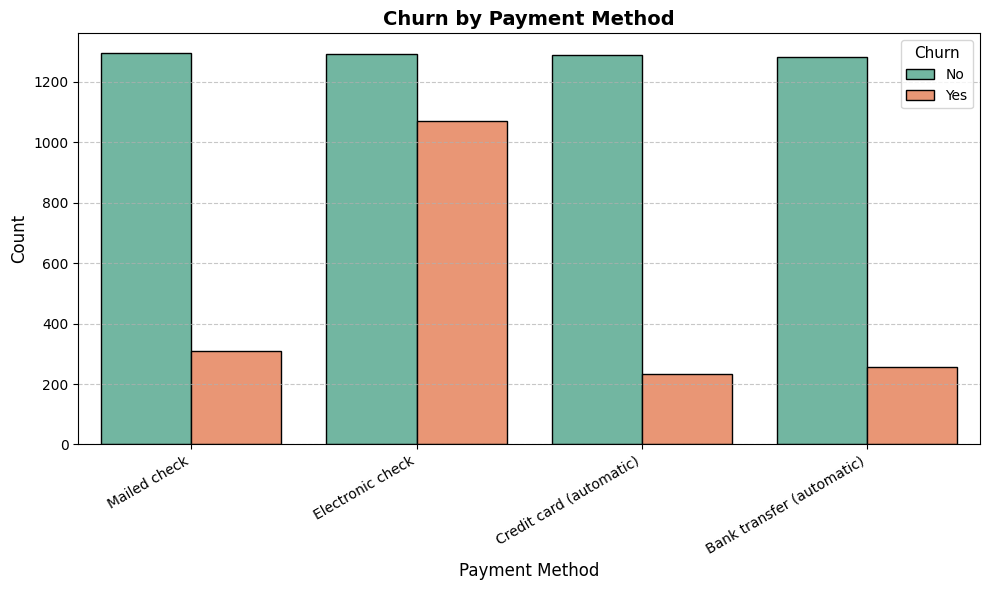

In [44]:
# Gráfico de barras: Churn por método de pagamento com refinamento visual
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x='PaymentMethod',
    hue='Churn',
    palette=['#66c2a5', '#fc8d62'],  # Cores mais claras e com contraste
    edgecolor='black'
)

plt.title('Churn by Payment Method', fontsize=14, weight='bold')
plt.xlabel('Payment Method', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Churn', title_fontsize=11, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar o layout e salvar como imagem
plt.tight_layout()
plt.savefig('churn_by_payment_method.png', dpi=300, bbox_inches='tight')

plt.show()


## 11. Exportação dos Dados Tratados

### 11.1 Arredondamento de Colunas Numéricas

In [45]:
# Arredondar coluna numérica
df['DailyCharges'] = df['DailyCharges'].round(2)

### 11.2 Exportação para CSV

In [46]:
# Exportar para CSV e Excel
df.to_csv('TelecomX_Data_Clean.csv', sep=';', decimal=',', index=False, encoding='utf-8-sig')

### 11.3 Exportação para Excel

In [47]:
df.to_excel('TelecomX_Data_Clean.xlsx', index=False)

## 12. Relatório Final e Interpretação dos Resultados

Este relatório sumariza a análise exploratória de dados realizada para compreender os fatores que contribuem para a evasão de clientes (Churn) na Telecom X.

***

### 12.1 Introdução

A Telecom X uma empresa de telecomunicações, enfrenta um desafio significativo: um alto índice de evasão de clientes, conhecido como *Churn*. A perda de clientes impacta diretamente a receita e o crescimento da empresa. Este projeto visa analisar os dados históricos dos clientes para identificar padrões e fatores que podem estar contribuindo para essa evasão.

***

### 12.2 Limpeza e Tratamento de Dados

* Dados carregados de um arquivo JSON aninhado `(TelecomX_Data.json)` e normalizados.

* **Padronizações realizadas:**

Valores ausentes em `TotalCharges` foram imputados com a **mediana**.

Remoção de 22 registros duplicados.

Conversão da variável `SeniorCitizen` para categórico ('Yes'/'No').

Substituição de `'No internet service'` e `'No phone service'` por `'No'`.

* **Variáveis Derivadas Criadas e Alteradas**

    * **DailyCharges:** gasto médio diário.

    * **ServiceCount:** número de serviços ativos.

    * **AvgServiceCost:** gasto médio por serviço ativo.

    * **TenureGroup:** agrupamento do tempo de contrato em faixas.

---

#### Informações Gerais do Conjunto de Dados:


| Coluna           | Non-Null Count | Dtype   |
| ---------------- | -------------- | ------- |
| Gender           | 7032           | object  |
| SeniorCitizen    | 7032           | object  |
| Partner          | 7032           | object  |
| Dependents       | 7032           | object  |
| Tenure           | 7032           | int64   |
| PhoneService     | 7032           | object  |
| MultipleLines    | 7032           | object  |
| InternetService  | 7032           | object  |
| OnlineSecurity   | 7032           | object  |
| OnlineBackup     | 7032           | object  |
| DeviceProtection | 7032           | object  |
| TechSupport      | 7032           | object  |
| StreamingTV      | 7032           | object  |
| StreamingMovies  | 7032           | object  |
| Contract         | 7032           | object  |
| PaperlessBilling | 7032           | object  |
| PaymentMethod    | 7032           | object  |
| MonthlyCharges   | 7032           | float64 |
| DailyCharges     | 7032           | float64 |
| AvgServiceCost   | 5736           | float64 |
| TotalCharges     | 7032           | float64 |
| ServiceCount     | 7032           | int64   |
| Churn            | 7032           | object  |

---

### 12.3 Estatísticas Descritivas das Variáveis Numéricas


| Variável       | Média   | Mediana | Desvio Padrão | Mínimo | Máximo  |
| -------------- | ------- | ------- | ------------- | ------ | ------- |
| Tenure         | 32.37   | 29.00   | 24.58         | 1.00   | 72.00   |
| MonthlyCharges | 64.80   | 70.35   | 30.09         | 18.25  | 118.75  |
| TotalCharges   | 2281.92 | 1394.55 | 2265.27       | 18.80  | 8684.80 |
| ServiceCount   | 2.94    | 3.00    | 1.84          | 0.00   | 7.00    |

---

### 12.4 Análise Exploratória de Dados (EDA)

**Distribuição da Variável Churn**
* Desbalanceamento de classes:

 * 73.46% de clientes permaneceram.

 * 26.54% de clientes evadiram (churn).

**Correlações e Médias Agrupadas por Churn**

* `Tenure` e `TotalCharges`: correlação muito forte e positiva (0.825).

* `MonthlyCharges` e `TotalCharges`: forte correlação positiva (0.651).

* Cramér’s V entre `Contract` e `Churn`: 0.62 (forte associação).


| Métrica        | Churn: No | Churn: Yes |
| -------------- | --------- | ---------- |
| Tenure (média) | 37.57     | 17.98      |
| TotalCharges   | 2644.76   | 1531.80    |
| MonthlyCharges | 61.27     | 74.44      |
| ServiceCount   | 3.14      | 2.27       |

---

#### 12.5 Padrões Relevantes

**Forte Impacto:**
* Contract (Month-to-month): churn mais elevado.

* InternetService (Fiber optic): alta taxa de churn.

* Ausência de OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport.

* PaymentMethod (Electronic check).

* PaperlessBilling: associado a maior churn.

**Impacto Moderado:**

* SeniorCitizen: Yes

* Partner: No, Dependents: No

**Baixo Impacto:**

* Gender

* PhoneService

* MultipleLines

* StreamingTV, StreamingMovies

---

#### 12.6 Padrões por Variáveis Numéricas

* **Tenure:** churn concentrado em clientes com até 24 meses.

* **MonthlyCharges:** churn maior em clientes com altos valores.

* **TotalCharges:** churn mais comum em valores baixos.

* **DailyCharges:** churn associado a gastos diários altos com baixa fidelização.

* **ServiceCount:** churn maior com poucos serviços contratados.

---

#### 12.7 Análise Temporal de Fidelidade

| Faixa de Tenure (meses) | Churn Rate (%) |
| ----------------------- | -------------- |
| 0 – 12                  | Elevado        |
| 13 – 24                 | Alto           |
| 25 – 48                 | Moderado       |
| 49 – 72                 | Baixo          |

A fidelidade aumenta com o tempo de contrato.

---

### 12.8 Conclusões

**Fatores mais relevantes para evasão:**

* **Contrato:** contratos mensais têm alta taxa de churn.

* **Tenure:** clientes novos apresentam maior risco.

* **Serviços Adicionais:** ausência está fortemente ligada à evasão.

* **Custo Mensal:** mensalidades elevadas contribuem para churn.

* **Método de Pagamento:** Electronic check está associado à maior evasão.

* **Demografia:** idosos, solteiros e sem dependentes evadem mais.

* **Tipo de Internet:** clientes de fibra óptica mostram churn acima da média.

---

#### 12.9 Perfil do Cliente com Alto Risco de Churn

Cliente com:

* Contrato mensal

* Pouco tempo de fidelidade

* Pagamento via cheque eletrônico

* Internet via fibra óptica

* Sem serviços de suporte ou segurança

* Mensalidade alta

* Idoso, sem parceiro e sem dependentes

---

### 12.10 Recomendações Estratégicas

- Fidelização inicial: programas de retenção nos primeiros 6–12 meses.

- Contratos longos: incentivos para migração a planos anuais.

- Serviços adicionais: promover segurança e suporte técnico.

- Fibra óptica: revisar planos e atendimento.

- Pagamento: melhorar experiência do cliente com Electronic check.

- Campanhas personalizadas: ofertas para perfis de risco com suporte dedicado.



